In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import h5py
import itertools

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from matplotlib.pyplot import imread
import glob
import os
import random
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import torch.nn as nn
from torchvision.models import alexnet, vgg16, resnet152, resnet18, vgg19

%matplotlib inline

import matplotlib.pyplot as plt
import math

import torch.nn.functional as nnf
from torch.utils.data import random_split
from torch.optim import SGD 
from torch.distributions import constraints
import torchvision as torchv
import torchvision.transforms as torchvt
import pickle

from sklearn.metrics import classification_report, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [2]:
# Function for moving tensor or model to GPU
def cuda(xs):
    if torch.cuda.is_available():
        if not isinstance(xs, (list, tuple)):
            return xs.cuda()
        else:
            return [x.cuda() for x in xs]
    else:
        return xs

# Custom class for defining dataset for training with augmentation
class Dataset_Hdf5(Dataset):

    def __init__(self, path, data_type):
        """ Intialize the dataset
        """
        self.path = path
        self.file = h5py.File(path, 'r')
        self.images = self.file['x_{}'.format(data_type)]
        self.labels = self.file['y_{}'.format(data_type)]
                
        self.len = self.images.shape[0]
        if data_type == 'train':
            # no augmentation as we are transforming heartbeats to images via gramian angular field
            self.transform = transforms.Compose([
#                                               transforms.ToPILImage(),
#                                               transforms.RandomRotation((0, 360)),
#                                               transforms.RandomHorizontalFlip(),
#                                               transforms.RandomVerticalFlip(),
                                              transforms.ToTensor()])
        else:
            self.transform = transforms.Compose([transforms.ToTensor()])

    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        # unsqueeze adds dimension to image -> converts to 1x224x224 since we don't have rgb
        return self.transform(self.images[index].astype('float32')), \
                torch.tensor(self.labels[index], dtype=torch.long)

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [3]:
# Yeah sorry, desktop is configured with my husband's name

# hb_train_loader = torch.utils.data.DataLoader(Dataset_Hdf5('/home/asif/heartbeat/hb_data_mit_bih.hdf5', 'train'), 
#                                                 batch_size=256, shuffle=True)
# hb_test_loader = torch.utils.data.DataLoader(Dataset_Hdf5('/home/asif/heartbeat/hb_data_mit_bih.hdf5', 'test'), 
#                                                 batch_size=256, shuffle=False)

In [4]:
# hb_train_loader_bln = torch.utils.data.DataLoader(Dataset_Hdf5('/home/asif/heartbeat/hb_data_mit_bih_balanced.hdf5', 'train'), 
#                                                 batch_size=512, shuffle=True)
# hb_test_loader_bln = torch.utils.data.DataLoader(Dataset_Hdf5('/home/asif/heartbeat/hb_data_mit_bih_balanced.hdf5', 'test'), 
#                                                 batch_size=256, shuffle=False)

In [5]:
hb_train_loader_bln_2 = torch.utils.data.DataLoader(Dataset_Hdf5('/home/asif/heartbeat/hb_data_mit_bih_balanced_2.hdf5', 'train'), 
                                                batch_size=512, shuffle=True)
hb_test_loader_bln_2 = torch.utils.data.DataLoader(Dataset_Hdf5('/home/asif/heartbeat/hb_data_mit_bih_balanced_2.hdf5', 'test'), 
                                                batch_size=256, shuffle=False)

In [6]:
hb_train_loader_bln_3 = torch.utils.data.DataLoader(Dataset_Hdf5('/home/asif/heartbeat/hb_data_mit_bih_balanced_3.hdf5', 'train'), 
                                                batch_size=512, shuffle=True)
hb_test_loader_bln_3 = torch.utils.data.DataLoader(Dataset_Hdf5('/home/asif/heartbeat/hb_data_mit_bih_balanced_3.hdf5', 'test'), 
                                                batch_size=256, shuffle=False)

In [1]:
# alex_net = alexnet(pretrained=True)
# alex_net

In [7]:
res_net = resnet18(pretrained=True)
# First we freeze all layers
for param in res_net.parameters():
    param.requires_grad = False # frozen layer

# Now we make later layers trainable
for param in res_net.layer4.parameters():
    param.requires_grad = True
for param in res_net.layer3.parameters():
    param.requires_grad = True
for param in res_net.avgpool.parameters():
    param.requires_grad = True
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = res_net.fc.in_features
# Replace 1 FC with 3 new FC
res_net.fc = nn.Sequential(
                nn.Linear(in_features=num_ftrs, out_features=256, bias=False),
                nn.ReLU(),
                nn.Linear(in_features=256, out_features=128, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=128, out_features=5, bias=True))
 
# Move ResNet to GPU
res_net.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [6]:
# alex_net = alexnet(pretrained=True)
# alex_net.classifier = nn.Sequential(
#                 nn.Dropout(p=0.5),
#                 nn.Linear(in_features=9216, out_features=4096, bias=True),
#                 nn.ReLU(inplace=True),
#                 nn.Dropout(p=0.5),
#                 nn.Linear(in_features=4096, out_features=2048, bias=True),
#                 nn.ReLU(inplace=True),
#                 nn.Dropout(p=0.5),
#                 nn.Linear(in_features=2048, out_features=1024, bias=True),
#                 nn.ReLU(inplace=True),
#                 nn.Linear(in_features=1024, out_features=5, bias=True)
#                )

# for param in alex_net.parameters():
#     param.requires_grad = False # frozen layer


# # Now we make later layers trainable
# for param in alex_net.avgpool.parameters():
#     param.requires_grad = True
# for param in alex_net.classifier.parameters():
#     param.requires_grad = True

In [2]:
# alex_net.cuda()

In [8]:
# Since 2nd and 4th classes contained less data we assign more weights to them
class_weights = cuda(torch.tensor([1.0,2.0, 1.0, 2.0, 1.0]))
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [9]:
optimizer_res_net = torch.optim.Adam([
                                          {"params": res_net.layer3.parameters(), "lr": 0.001},
                                          {"params": res_net.layer4.parameters(), "lr": 0.001},
                                          {"params": res_net.avgpool.parameters(), "lr": 0.001},    
                                          {"params": res_net.fc[0].parameters(), "lr": 0.001},
                                          {"params": res_net.fc[2].parameters(), "lr": 0.001},
                                          {"params": res_net.fc[4].parameters(), "lr": 0.002},
                                           ],  
                                lr=0.0001, betas=(0.5, 0.999))

In [10]:
def train(net, train_loader, criterion, optimizer, test_loader, num_epochs=25):
    net.train()
    train_acc_max = 0
    test_acc_max = 0
    recall_max = 0
    f1_max = 0

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        net.train()

        total = 0
        correct = 0
   
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = cuda(data)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.expand(-1, 3, -1, -1)) # converting to RGB
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        
        scheduler.step()
        
        print('End of epoch {}, Loss {}'.format(epoch + 1, running_loss / len(train_loader)))
        
        train_acc = correct / total
        print('Train accuracy: {}'.format(train_acc))
        test_acc, all_true, all_pred = test(net, test_loader)
        print('Test accuracy: {}'.format(test_acc))
        print(classification_report(all_true, all_pred, target_names=['N', 'S', 'V', 'F', 'Q']))
        recall = recall_score(all_true, all_pred, average='macro')
        f1 = f1_score(all_true, all_pred, average='macro')
        
        # Saving best checkpoint based on performance on test data            
        if recall > recall_max:
            recall_max = recall
            save_checkpoint(epoch + 1, net, optimizer, train_acc, test_acc, recall, f1, 'res_net', 'test_recall')
            
        if f1 > f1_max:
            f1_max = f1
            save_checkpoint(epoch + 1, net, optimizer, train_acc, test_acc, recall, f1, 'res_net', 'test_f1')

    print('Finished Training')
    
def test(net, test_loader):
    net.eval()
    correct = 0
    total = 0
    all_true = []
    all_pred = []
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = cuda(data)
            all_true.extend(labels.cpu().tolist())
            outputs = net(images.expand(-1, 3, -1, -1))
            _, predicted = torch.max(outputs, 1)
            all_pred.extend(predicted.cpu().tolist())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
#     print('Accuracy of the network on the images: %d %%' % (100 * acc))
    return acc, all_true, all_pred

def save_checkpoint(epoch, net, optimizer, train_acc, test_acc, recall, f1, net_name, param):
    checkpoint = {
        'net': net.state_dict(),
        'optimizer': optimizer.state_dict(),
        'train_acc': train_acc,
        'test_acc': test_acc,
        'recall': recall,
        'f1': f1
    }
    torch.save(checkpoint, '{}_{}_best.chk'.format(net_name, param))

In [10]:
train(alex_net, hb_train_loader_bln, criterion, optimizer_alex_net, hb_test_loader, 10)

End of epoch 1, Loss 0.35651192449185315
Train accuracy: 0.87148
Test accuracy: 0.834920634920635
              precision    recall  f1-score   support

           N       0.93      0.48      0.64       819
           S       0.65      0.92      0.76       819
           V       0.91      0.88      0.89       819
           F       0.83      0.95      0.89       819
           Q       0.99      0.94      0.97       819

    accuracy                           0.83      4095
   macro avg       0.86      0.83      0.83      4095
weighted avg       0.86      0.83      0.83      4095

End of epoch 2, Loss 0.18074556675796605
Train accuracy: 0.93522
Test accuracy: 0.9023199023199023
              precision    recall  f1-score   support

           N       0.81      0.89      0.85       819
           S       0.91      0.81      0.86       819
           V       0.94      0.88      0.91       819
           F       0.88      0.95      0.92       819
           Q       0.98      0.98      0.98

In [11]:
train(res_net, hb_train_loader_bln_3, criterion, optimizer_res_net, hb_test_loader_bln_3, 10)

End of epoch 1, Loss 0.10883385003638148
Train accuracy: 0.9615861376917578
Test accuracy: 0.939795359035264
              precision    recall  f1-score   support

           N       0.99      0.94      0.96     18118
           S       0.32      0.90      0.48       556
           V       0.94      0.96      0.95      1448
           F       0.64      0.88      0.74       162
           Q       0.99      0.98      0.99      1608

    accuracy                           0.94     21892
   macro avg       0.78      0.93      0.82     21892
weighted avg       0.97      0.94      0.95     21892

End of epoch 2, Loss 0.03558101612705762
Train accuracy: 0.9877616071252894
Test accuracy: 0.9823223095194592
              precision    recall  f1-score   support

           N       0.99      1.00      0.99     18118
           S       0.87      0.79      0.83       556
           V       0.98      0.93      0.95      1448
           F       0.76      0.80      0.78       162
           Q       0.

In [12]:
ckpt_recall = torch.load('res_net_test_recall_best.chk')
res_net_saved_recall = resnet18(pretrained=True)
for param in res_net_saved_recall.parameters():
    param.requires_grad = False
    
num_ftrs = res_net_saved_recall.fc.in_features
res_net_saved_recall.fc = nn.Sequential(
                nn.Linear(in_features=num_ftrs, out_features=256, bias=False),
                nn.ReLU(),
                nn.Linear(in_features=256, out_features=128, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=128, out_features=5, bias=True))
res_net_saved_recall.load_state_dict(ckpt_recall['net'])
res_net_saved_recall.cuda()    

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [13]:
ckpt_f1 = torch.load('res_net_test_f1_best.chk')
res_net_saved_f1 = resnet18(pretrained=True)
for param in res_net_saved_f1.parameters():
    param.requires_grad = False
    
num_ftrs = res_net_saved_f1.fc.in_features
res_net_saved_f1.fc = nn.Sequential(
                nn.Linear(in_features=num_ftrs, out_features=256, bias=False),
                nn.ReLU(),
                nn.Linear(in_features=256, out_features=128, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=128, out_features=5, bias=True))
res_net_saved_f1.load_state_dict(ckpt_f1['net'])
res_net_saved_f1.cuda()   

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [14]:
test_acc_r, all_true_r, all_pred_r = test(res_net_saved_recall, hb_test_loader_bln_3)

In [22]:
test_acc_f, all_true_f, all_pred_f = test(res_net_saved_f1, hb_test_loader_bln_3)

In [18]:
# From sklearn
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
# Compute confusion matrix
def compute_confusion_matrix(all_true, all_pred):
    class_names=['N', 'S', 'V', 'F', 'Q']

    cnf_matrix = confusion_matrix(all_true, all_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

Confusion matrix, without normalization
[[16967  1018    69    54    10]
 [   44   502     6     3     1]
 [   26    12  1386    21     3]
 [   10     1     9   142     0]
 [    8    14     8     1  1577]]
Normalized confusion matrix
[[9.36e-01 5.62e-02 3.81e-03 2.98e-03 5.52e-04]
 [7.91e-02 9.03e-01 1.08e-02 5.40e-03 1.80e-03]
 [1.80e-02 8.29e-03 9.57e-01 1.45e-02 2.07e-03]
 [6.17e-02 6.17e-03 5.56e-02 8.77e-01 0.00e+00]
 [4.98e-03 8.71e-03 4.98e-03 6.22e-04 9.81e-01]]


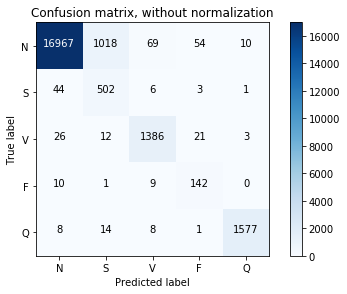

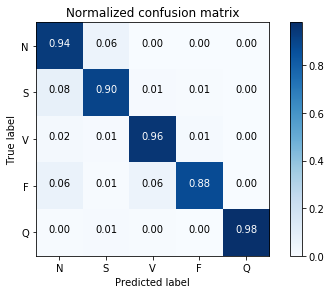

In [20]:
compute_confusion_matrix(all_true_r, all_pred_r)

Confusion matrix, without normalization
[[18034    64    13     4     3]
 [   83   465     4     3     1]
 [   36     3  1388    16     5]
 [   16     1    16   129     0]
 [   14     1     4     0  1589]]
Normalized confusion matrix
[[9.95e-01 3.53e-03 7.18e-04 2.21e-04 1.66e-04]
 [1.49e-01 8.36e-01 7.19e-03 5.40e-03 1.80e-03]
 [2.49e-02 2.07e-03 9.59e-01 1.10e-02 3.45e-03]
 [9.88e-02 6.17e-03 9.88e-02 7.96e-01 0.00e+00]
 [8.71e-03 6.22e-04 2.49e-03 0.00e+00 9.88e-01]]


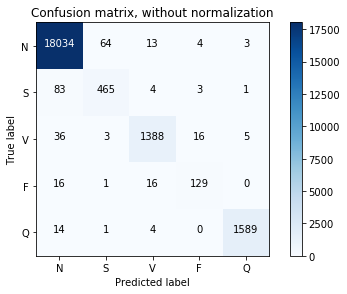

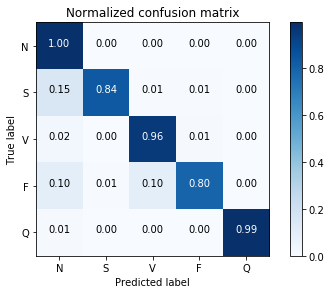

In [23]:
compute_confusion_matrix(all_true_f, all_pred_f)